In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os
from Bio.Seq import Seq

sys.path.append("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/")
from scripts import initial_map, map_refiner, complexity, finder, preprocess, error_correct, plotting, umi_deduplicate


from tqdm import tqdm  # progress bar

# 1. AD 

In [3]:
# UPDATE list of files and output location
AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a*")
RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/r*")
output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results" # May need to change to your directory due to writing permissions

# Change below as needed to update barcode info, csv path to final step1 map, and desired output directory


step1_ADBC2 = finder.Barcode(name = "ADBC2",
                       preceder = "TATGCTAT",
                       post = "GGCCGGCCG",
                       length = 6)

step1_HawkBCs = finder.Barcode(name = "HawkBCs",
                       preceder = "TAGC",
                       post = "CTCGAGA",
                       length = 9)

step1_RTBC = finder.Barcode(name = "RTBC",
                       preceder = "GCCCC",
                       post = "GCGG",
                       length = 16)

# Step 1 map
step1_csv = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2_whitelist_concat_density_step1_map.csv"  # Step 1 map I made with error correcting 

In [4]:
db_path = os.path.join(output_path, "NKX2-2_CC_UMI_whitelisted_concat_custom_threshold_redone.db")

In [5]:
AD_objects = [step1_ADBC2, step1_HawkBCs]

In [6]:
complex_AD_results = []
simple_AD_results = []

In [7]:
AD_seq_files

['/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a16_ADBC_Puro_Only_R4_T48_S88.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a15_ADBC_Puro_Only_R3_T48_S93.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a5_ADBC_Puro_Only_R1_T4_S94.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a11_ADBC_Puro_Only_R3_T24_S100.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a12_ADBC_Puro_Only_R4_T24_S101.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a19_ADBC_Puro_Only_R3_T0_S91.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a10_ADBC_Puro_Only_R2_T24_S99.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a6_ADBC_Puro_Only_R2_T4_S95.assembled.fastq',
 '/global/scratch/projects/

a16_ADBC_Puro_Only_R4_T48_S88
/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 30.23 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 9.20 seconds.

Extracting 2 barcodes...
Regex for ADBC2: TATGCTAT(.*)GGCCGGCCG
Regex for HawkBCs: TAGC(.*)CTCGAGA
Done in 3.82 seconds.

Extracting UMI...
UMI: extracting last 12 bases
Done in 0.77 seconds.



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 7.54 seconds.

Mapping complete.
umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_initial
Total rows: 14202214


,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,UMI,UMI_qual,Designed
0,GTATAA,True,CCATTAACG,True,CTGTGTTGTANT,True,1
1,ACGACA,True,CAAGGAACA,True,GCTGCGTGGTNT,True,1
2,TAACCA,True,CAGATATGG,True,TCGGGTCTCANA,True,1
3,AAATAC,True,CACAAGGAC,True,GTCTAACTTANC,True,1
4,CACTAT,True,CAAGACCTA,True,TGATGTAAGTNG,True,1


refining
Base prefix (stable across descriptors): umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_
Full prefix for this instance: umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_

Using the following step order:
1. initial
2. quality
3. error_corrected


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_quality — filtered for TRUE in all *_qual columns.
Done in 7.12 seconds.


=== Running error correction step on umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_quality ===

=== Applying whitelist for umi_a16_ADBC_Puro_Only_R4_T48_S88 ===
Generating FASTQ: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_filtered_barcodes_extracted.fastq
Wrote 13584327 reads to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_filtered_barcodes_extracted.fastq
Done in 7.94 seconds.

Inferring expected barcode count from grouped reads...
Using reads threshold of 15
Inferred expected barcode count: 1778
Running umi_tools whitelist...
Using custom cell number.
Running umi_tools whitelist on umi_a16_ADBC_Puro_Only_R4_T48_S88

/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/umi_tools/lib/python3.12/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)



Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_filtered_barcodes_extracted_plots_*.png
Unique canonical barcodes: 1778


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.63 seconds.

Whitelist application complete for umi_a16_ADBC_Puro_Only_R4_T48_S88 at umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_error_corrected
Done in 3.17 minutes.

Done.
Saved loss summary table as 'umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_loss_summary'
Done in 0.11 seconds.

['/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.txt']
Saved barcode whitelist plots: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_whitelist_summary.png


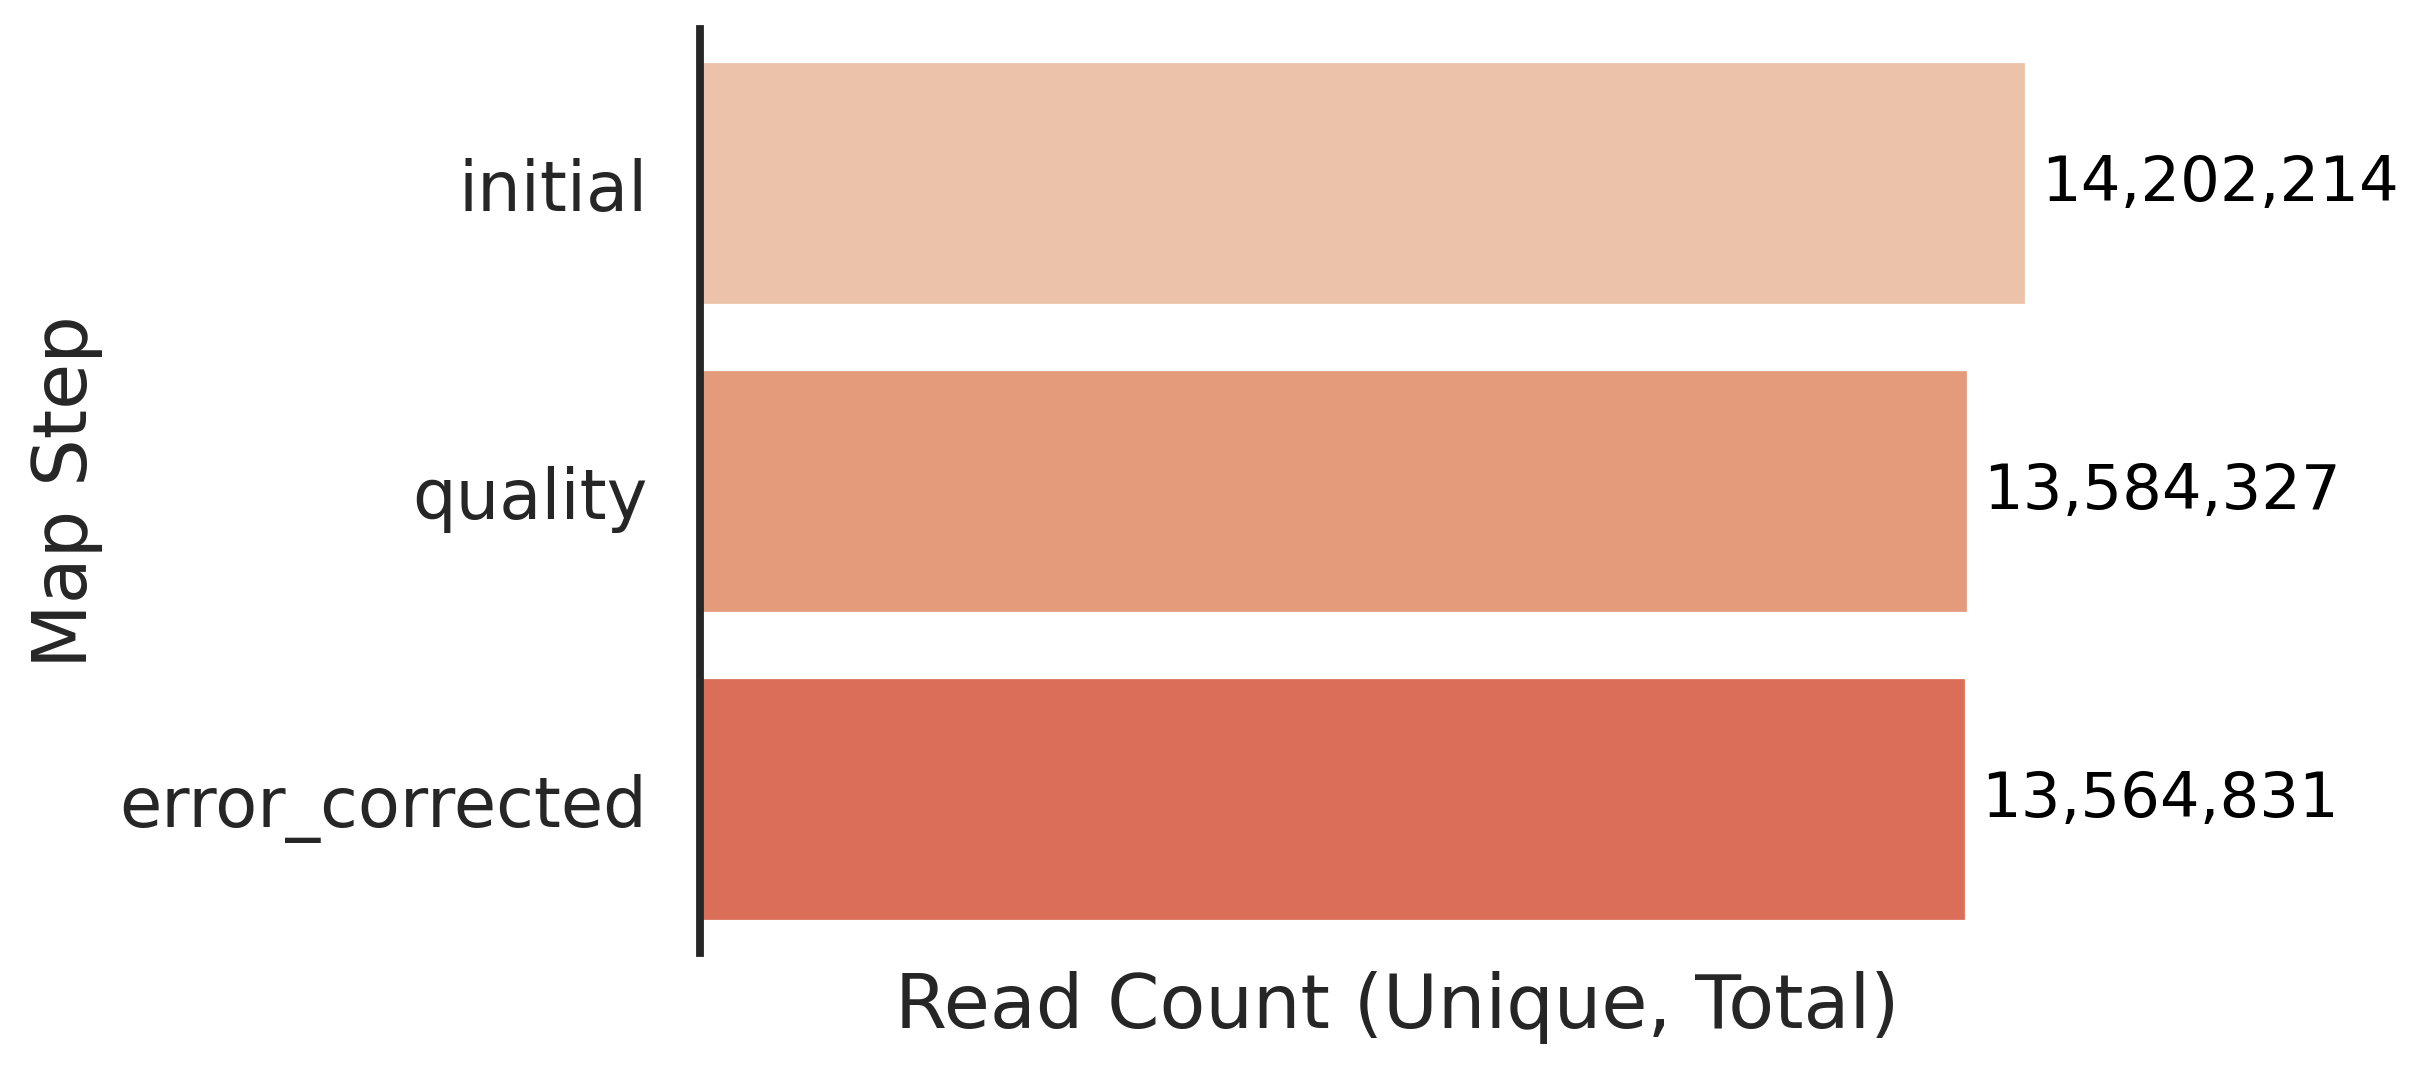

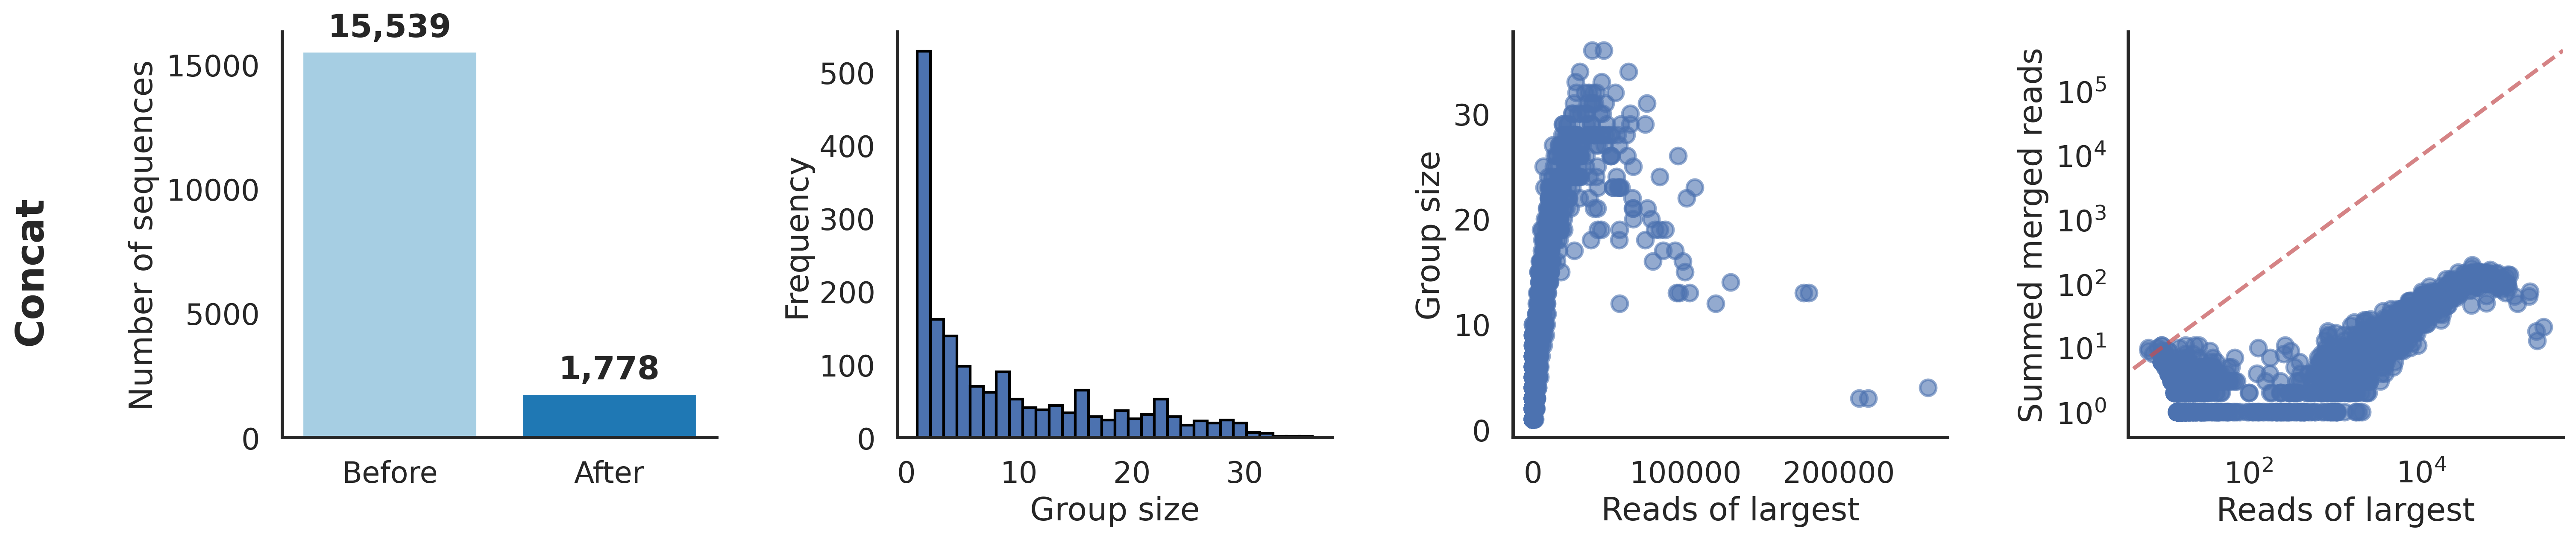

Done in 3.04 seconds.

Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Writing FASTQ to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/a16_ADBC_Puro_Only_R4_T48_S88_umi_extracted.fastq (13564831 reads)...


Writing FASTQ: 100%|██████████| 13564831/13564831 [00:08<00:00, 1653736.07it/s]


FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/a16_ADBC_Puro_Only_R4_T48_S88_umi_extracted.fastq
Done in 16.24 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/a16_ADBC_Puro_Only_R4_T48_S88_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/a16_ADBC_Puro_Only_R4_T48_S88_barcodes_index


Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/a16_ADBC_Puro_Only_R4_T48_S88_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/a16_ADBC_Puro_Only_R4_T48_S88_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/a16_ADBC_Puro_Only_R4_T48_S88_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/a16_ADBC_Puro_Only_R4_T48_S88_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/a16_ADBC_Puro_Only_R4_T48_S88_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R

Done in 3.48 seconds.

Aligning .FASTQ to reference .FA ...


13564831 reads; of these:
  13564831 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    13564831 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/a16_ADBC_Puro_Only_R4_T48_S88_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a16_ADBC_Puro_Only_R4_T48_S88/a16_ADBC_Puro_Only_R4_T48_S88_umi_deduplicated.bam
# job started at Thu Jan 15 09:27:27 2026 on n0179.savio2 -- a7de02a9-e07d-43ad-9e3e-f4246118185e
# pid: 1440792, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method           

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 40.46 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 12.23 seconds.

Extracting 2 barcodes...
Regex for ADBC2: TATGCTAT(.*)GGCCGGCCG


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Regex for HawkBCs: TAGC(.*)CTCGAGA
Done in 5.29 seconds.

Extracting UMI...
UMI: extracting last 12 bases
Done in 1.01 seconds.



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 6.95 seconds.

Mapping complete.
umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_initial
Total rows: 19123611


,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,UMI,UMI_qual,Designed
0,TAACAG,True,CATCCACTA,True,TATCAACCTANG,True,1
1,CAGATA,True,CATGTTGCC,True,CTAGGTAAGANG,True,1
2,CTACGG,True,CATACGATC,True,AAAAGATTGANT,True,1
3,GTAGCT,True,CATCCACTA,True,TCGCCCGAATNT,True,1
4,ATTGGC,True,AACCTCTTC,True,GAATATGACANA,True,1


refining
Base prefix (stable across descriptors): umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_
Full prefix for this instance: umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_

Using the following step order:
1. initial
2. quality
3. error_corrected


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_quality — filtered for TRUE in all *_qual columns.
Done in 13.79 seconds.


=== Running error correction step on umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_quality ===

=== Applying whitelist for umi_a15_ADBC_Puro_Only_R3_T48_S93 ===
Generating FASTQ: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_filtered_barcodes_extracted.fastq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Wrote 18302090 reads to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_filtered_barcodes_extracted.fastq
Done in 11.14 seconds.

Inferring expected barcode count from grouped reads...
Using reads threshold of 15
Inferred expected barcode count: 2177
Running umi_tools whitelist...
Using custom cell number.
Running umi_tools whitelist on umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_filtered_barcodes_extracted.fastq ...


/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/umi_tools/lib/python3.12/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)



Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_filtered_barcodes_extracted_plots_*.png
Unique canonical barcodes: 2177


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.68 seconds.

Whitelist application complete for umi_a15_ADBC_Puro_Only_R3_T48_S93 at umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_error_corrected
Done in 3.50 minutes.

Done.
Saved loss summary table as 'umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_loss_summary'
Done in 0.02 seconds.

['/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_filtered_barcodes_extracted_whitelist.txt']
Saved barcode whitelist plots: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_whitelist_summary.png


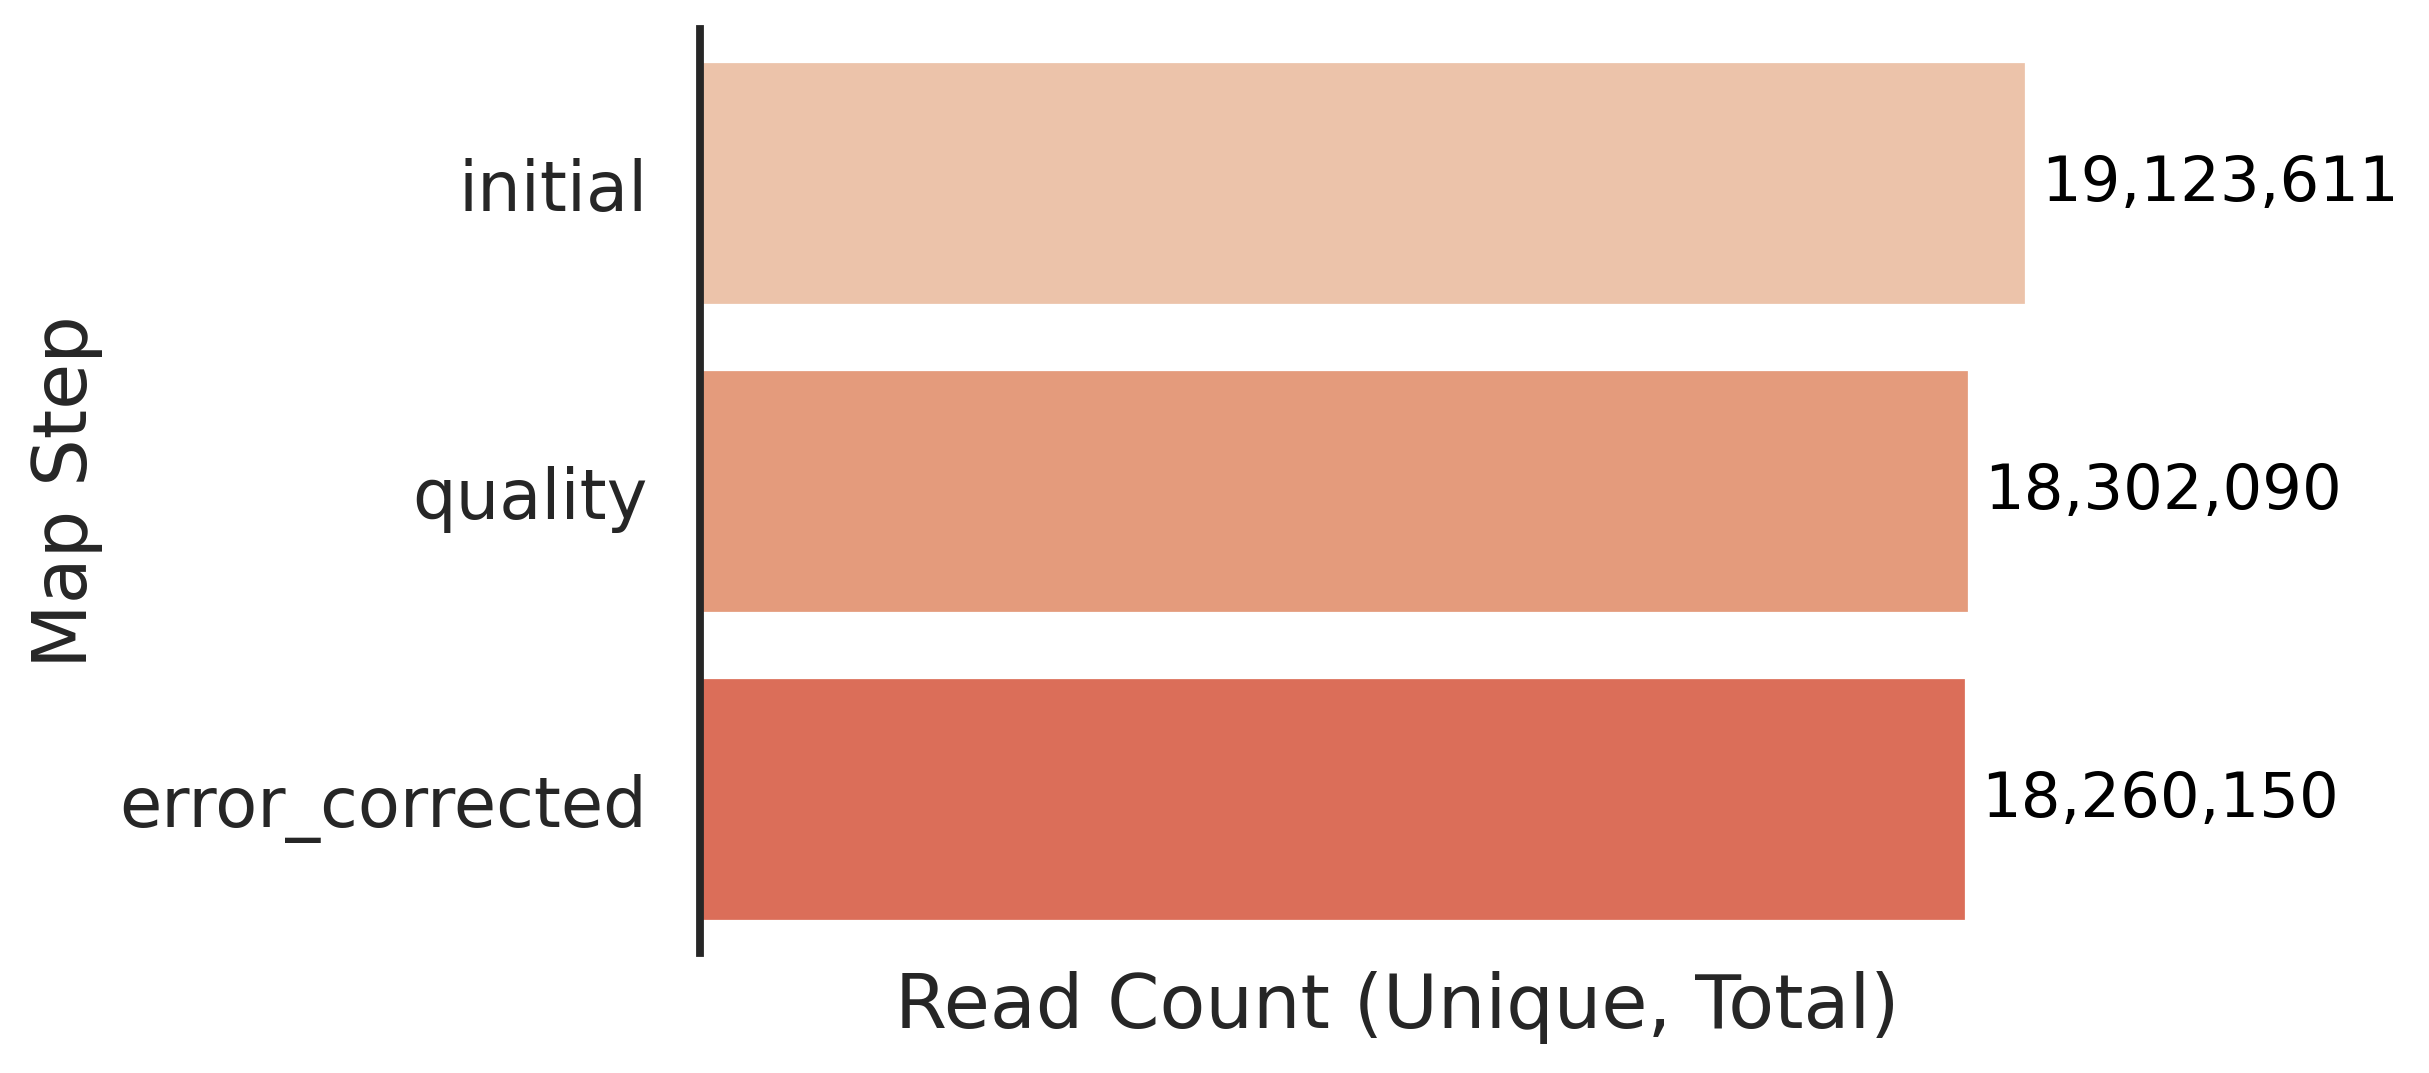

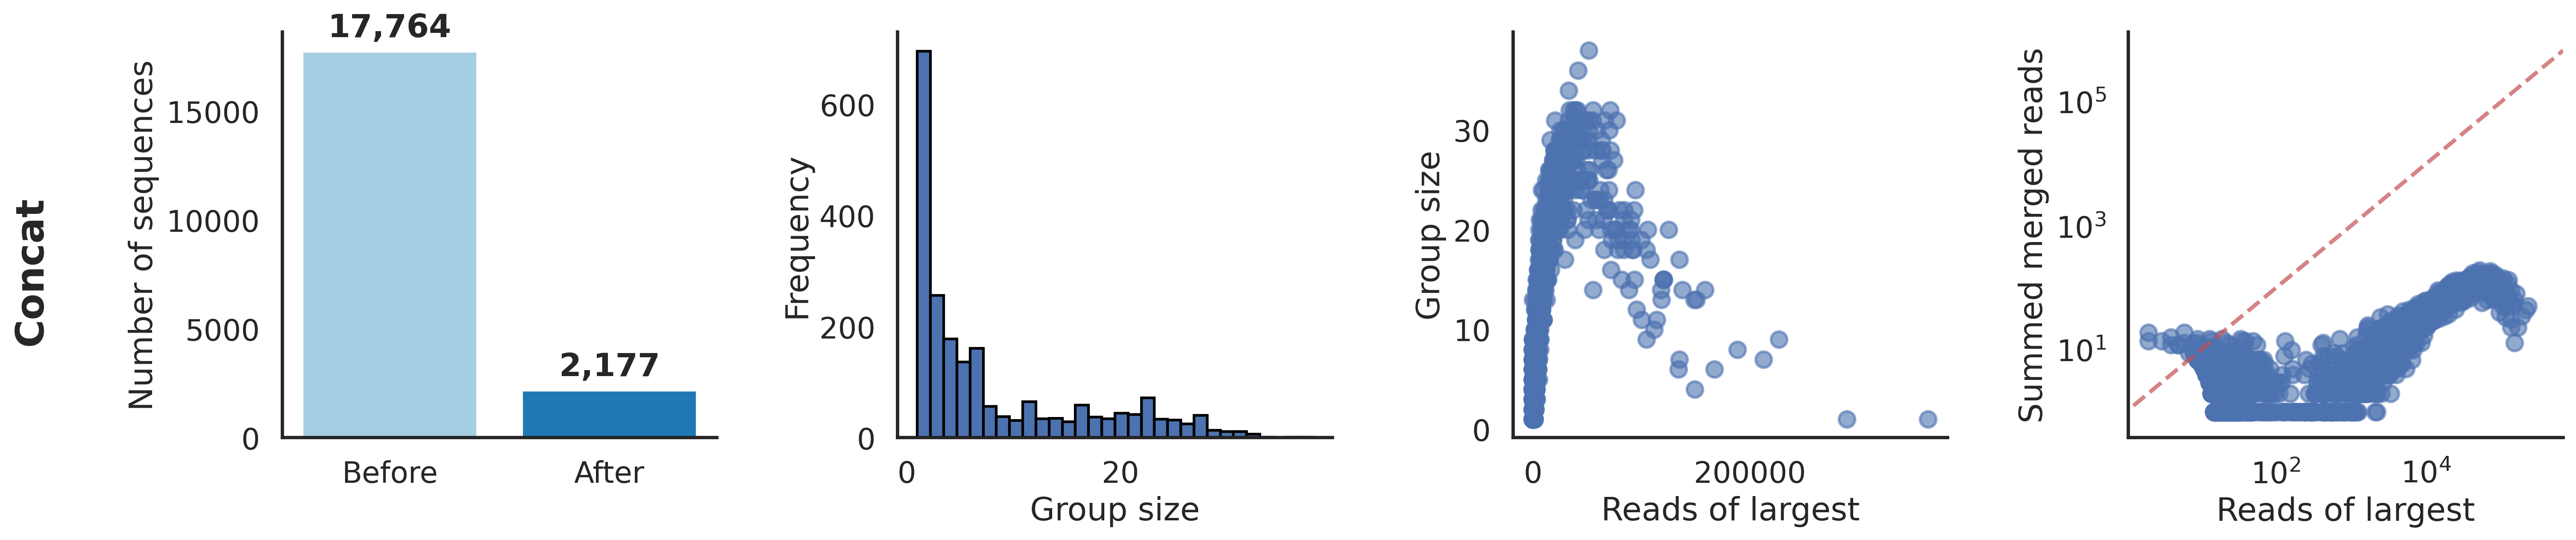

Done in 2.59 seconds.

Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Writing FASTQ to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/a15_ADBC_Puro_Only_R3_T48_S93_umi_extracted.fastq (18260150 reads)...


Writing FASTQ: 100%|██████████| 18260150/18260150 [00:09<00:00, 1837400.80it/s]


FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/a15_ADBC_Puro_Only_R3_T48_S93_umi_extracted.fastq
Done in 20.73 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/a15_ADBC_Puro_Only_R3_T48_S93_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/a15_ADBC_Puro_Only_R3_T48_S93_barcodes_index


Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/a15_ADBC_Puro_Only_R3_T48_S93_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/a15_ADBC_Puro_Only_R3_T48_S93_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/a15_ADBC_Puro_Only_R3_T48_S93_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/a15_ADBC_Puro_Only_R3_T48_S93_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/a15_ADBC_Puro_Only_R3_T48_S93_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R

Done in 1.66 seconds.

Aligning .FASTQ to reference .FA ...


18260150 reads; of these:
  18260150 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    18260150 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/a15_ADBC_Puro_Only_R3_T48_S93_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/umi_a15_ADBC_Puro_Only_R3_T48_S93/a15_ADBC_Puro_Only_R3_T48_S93_umi_deduplicated.bam
# job started at Thu Jan 15 09:52:54 2026 on n0179.savio2 -- 3617bd5a-44d9-4b0b-9d1b-17cc9492f293
# pid: 1441371, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method           

KeyboardInterrupt: 

In [8]:
for file_path in AD_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Get the file naeme to use for output
    umi_path = os.path.join(output_path, f"umi_{name_only}")
    print(umi_path)

    # Extract UMIs and barcodes from reads
    umi_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"umi_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = None,
                                       bc_objects = AD_objects,
                                       reverse_complement = True,
                                       umi_object= finder.Barcode(name = "UMI", preceder = "", post = "", length = 12))
    umi_mapper.create_map()
    display(umi_mapper.preview_map())

    print("refining")

    key = file_path.split("/")[-1].split(".")[0]
    
    # Only keep barcodes of correct length, then error correct
    # UPdated to use automatic reads threhsold detection for error correction
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=AD_objects,
                                        column_pairs = [],
                                        reads_threshold = 0,
                                        map_order = ['quality', 'error_corrected'],
                                        step_name=f"umi_{name_only}", 
                                        descriptor = "",
                                        output_figures_path = umi_path,
                                        manual_ec_threshold=False)

    # Use commented out block below to customize reads threhsold use for error correction
    # reads_threshold = None will prompt you for each file to look at histogram then enter threhsold
    # Or, if you know your reads threhsolds per file, replace None with the threshold
    # refiner = map_refiner.MapRefiner(db_path = db_path,
    #                                     bc_objects=AD_objects,
    #                                     column_pairs = [],
    #                                     reads_threshold = None,
    #                                     map_order = ['quality', 'error_corrected'],
    #                                     step_name=f"umi_{name_only}", 
    #                                     descriptor = "",
    #                                     output_figures_path = umi_path)
    
    refiner.refine_map_from_db()
    refiner.plot_loss()
    refiner.plot_error_correction()
    
    # # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = AD_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        output_path = umi_path,
                                                  refined_map_suffix = 'error_corrected')

    deduplicator.run_both_deduplications()

    # Collect results
    one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
    one_file_complex_results["name"] = name_only
    complex_AD_results.append(one_file_complex_results)

    one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
    one_file_simple_results["name"] = name_only
    simple_AD_results.append(one_file_simple_results)

# 2. RPTR

In [ ]:
RTBC_objects = [step1_RTBC]
RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/TL4_results/data/RNA/r*")

In [ ]:
complex_RT_results = []
simple_RT_results = []

In [ ]:
for file_path in RT_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Get the file naeme to use for output
    umi_path = os.path.join(output_path, f"umi_{name_only}")
    print(umi_path)

    # Extract UMIs and barcodes from reads
    umi_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"umi_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = None,
                                       bc_objects = RTBC_objects,
                                       reverse_complement = True,
                                       umi_object= finder.Barcode(name = "UMI", preceder = "", post = "", length = 12))
    umi_mapper.create_map()

    print("refining")

    key = file_path.split("/")[-1].split(".")[0]
    
    # Only keep barcodes of correct length, then error correct
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=RTBC_objects,
                                        column_pairs = [],
                                        reads_threshold = 0,
                                        map_order = ['quality', 'error_corrected'],
                                        step_name=f"umi_{name_only}", 
                                        descriptor = "",
                                    output_figures_path = umi_path,
                                    manual_ec_threshold = False)

    # Use commented out block below to customize reads threhsold use for error correction
    # reads_threshold = None will prompt you for each file to look at histogram then enter threhsold
    # Or, if you know your reads threhsolds per file, replace None with the threshold
    # refiner = map_refiner.MapRefiner(db_path = db_path,
    #                                     bc_objects=RTBC_objects,
    #                                     column_pairs = [],
    #                                     reads_threshold = None,
    #                                     map_order = ['quality', 'error_corrected'],
    #                                     step_name=f"umi_{name_only}", 
    #                                     descriptor = "",
    #                                     output_figures_path = umi_path)

    
    refiner.refine_map_from_db()
    refiner.plot_loss()
    refiner.plot_error_correction()
    
    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = RTBC_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        output_path = umi_path,
                                                       refined_map_suffix = 'error_corrected')

    deduplicator.run_both_deduplications()

    # Collect results
    one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
    one_file_complex_results["name"] = name_only
    complex_RT_results.append(one_file_complex_results)

    one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
    one_file_simple_results["name"] = name_only
    simple_RT_results.append(one_file_simple_results)

# Merge with step1 map

Combining results

In [ ]:
all_simple_AD_results_df = pd.concat(simple_AD_results)
all_simple_AD_results_df = all_simple_AD_results_df.rename(columns = {"count" : "AD_umi_count"})
all_simple_AD_results_df["ADBC_concat"] = all_simple_AD_results_df["ADBC2"] + all_simple_AD_results_df["HawkBCs"]
all_simple_AD_results_df["number"] = all_simple_AD_results_df["name"].str[1]
all_simple_AD_results_df

In [ ]:
all_complex_AD_results_df = pd.concat(complex_AD_results)
all_complex_AD_results_df = all_complex_AD_results_df.rename(columns = {"count" : "AD_umi_count"})
all_complex_AD_results_df = all_complex_AD_results_df.rename(columns = {"gene" : "ADBC_concat"})
all_complex_AD_results_df["number"] = all_complex_AD_results_df["name"].str[1]
all_complex_AD_results_df

In [ ]:
AD_results_merged = pd.merge(all_complex_AD_results_df, all_simple_AD_results_df, on = ["ADBC_concat", "name", "number"],suffixes = ("_complex", "_simple"))

In [ ]:
all_complex_RT_results_df = pd.concat(complex_RT_results)
all_complex_RT_results_df = all_complex_RT_results_df.rename(columns = {"count" : "RTBC_umi_count", "gene" : "RTBC"})
all_complex_RT_results_df["number"] = all_complex_RT_results_df["name"].str[1]
all_complex_RT_results_df

In [ ]:
all_simple_RT_results_df = pd.concat(simple_RT_results)
all_simple_RT_results_df = all_simple_RT_results_df.rename(columns = {"count" : "RTBC_umi_count"})
all_simple_RT_results_df["number"] = all_simple_RT_results_df["name"].str[1]
all_simple_RT_results_df

In [ ]:
RT_results_merged = pd.merge(all_complex_RT_results_df, all_simple_RT_results_df, on = ["RTBC", "name", "number"],suffixes = ("_complex", "_simple"))
RT_results_merged

In [ ]:
step1_map = pd.read_csv(step1_csv, index_col = 0)
step1_map

In [ ]:
# Concatenated ADBC2 and HawkBC
step1_map["ADBC_concat"] = step1_map["ADBC2"] + step1_map["HawkBCs"] 
step1_map

In [ ]:
# Add simple AD UMI counts to step1 map
step1_map_with_AD = pd.merge(step1_map, AD_results_merged).drop_duplicates()
step1_map_with_AD

In [ ]:
# Add RPTR UMI counts to step1 map
step1_map_with_RPTR = pd.merge(step1_map, RT_results_merged).drop_duplicates()
step1_map_with_RPTR

In [ ]:
merge_cols = set(step1_map_with_AD.columns) & set(step1_map_with_RPTR.columns)
merge_cols = [col for col in list(merge_cols) if col != "name"]
merge_cols

In [ ]:
step1_map_with_AD_RPTR = pd.merge(step1_map_with_AD, step1_map_with_RPTR, on = merge_cols, how = 'outer', suffixes = ("_AD", "_RPTR"))
step1_map_with_AD_RPTR = step1_map_with_AD_RPTR.fillna(0)
step1_map_with_AD_RPTR

In [ ]:
# Now, break down into a better more manageable table
# 1	R1N 24
# 2	R1incuded 24
# 3	R2N 24
# 4	R2Induced 24
# 5	R1N 48
# 6	R1incuded 48
# 7	R2N 48
# 8	R2Induced 48

# Define a mapping for each attribute
# mapping = {
#     "1": {"Replicate": "R1", "Induced": "No",  "Time": 24},
#     "2": {"Replicate": "R1", "Induced": "Yes", "Time": 24},
#     "3": {"Replicate": "R2", "Induced": "No",  "Time": 24},
#     "4": {"Replicate": "R2", "Induced": "Yes", "Time": 24},
#     "5": {"Replicate": "R1", "Induced": "No",  "Time": 48},
#     "6": {"Replicate": "R1", "Induced": "Yes", "Time": 48},
#     "7": {"Replicate": "R2", "Induced": "No",  "Time": 48},
#     "8": {"Replicate": "R2", "Induced": "Yes", "Time": 48},
# }

# # Expand mapping into separate columns
# step1_map_with_AD_RPTR = step1_map_with_AD_RPTR.join(step1_map_with_AD_RPTR["number"].map(mapping).apply(pd.Series))
# step1_map_with_AD_RPTR

In [ ]:
# Final results 
final_results = step1_map_with_AD_RPTR
final_results

In [ ]:
final_results[final_results["RTBC"] == "TAACCTAGCTTCGTCG"]

In [ ]:
#231 distinct ADs in final results
final_results["Designed"].value_counts()

In [ ]:
final_results.to_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/results/results_with_step1_redone_puro_only.csv")

# Reads loss

In [4]:
# step1_map = pd.read_csv(step1_csv, index_col = 0)
# step1_map

# fig, axes = plt.subplots(2, 8, figsize=(24,6), dpi=300, sharey=True, sharex = False)
# axes = axes.flatten()  # flatten to index easily 0..15

# # First row: AD (ADBC/HawkBCs)
# for i in np.arange(1, 9):
#     file_name = f'umi_a{i}_RNA_ADBC_S{16 + i}_ADBC2_HawkBCs_error_corrected'
#     df = refiner.get_map_df(file_name)
    
#     total_count = len(df)
#     both_true = ((df["ADBC2_qual"]) & (df["HawkBCs_qual"])).sum()
#     step1_count = len(df[(df["ADBC2"].isin(step1_map["ADBC2"])) & (df["HawkBCs"].isin(step1_map["HawkBCs"]))])
#     print(f"{file_name} step1 count: {step1_count}")

#     plot_counts = pd.DataFrame({
#         "Category": ["Total", "BC\nQual", "In\nStep1"],
#         "Count": [total_count, both_true, step1_count]
#     })

#     ax = axes[i - 1]
#     sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

#     ax.set_title("Group " + str(file_name[:6][-1]), fontsize='medium')
#     ax.set_xlabel("")
#     ax.set_ylabel("")

# # Second row: RPTR (RTBC)
# for i in np.arange(1, 9):
#     file_name = f'umi_r{i}_RNA_RTBC_S{24 + i}_RTBC_error_corrected'
#     df = refiner.get_map_df(file_name)
    
#     total_count = len(df)
#     true_count = df["RTBC_qual"].sum()  # assuming boolean True/False
#     step1_count = len(df[df["RTBC"].isin(step1_map["RTBC"])])
   
#     plot_counts = pd.DataFrame({
#         "Category": ["Total", "BC\nQual", "In\nStep1"],
#         "Count": [total_count, true_count, step1_count]
#     })

#     ax = axes[8 + i - 1]
#     sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

#     #ax.set_title(file_name[:6], fontsize='medium')
#     ax.set_xlabel("")
#     ax.set_ylabel("")

# axes[0].set_ylabel("Concat.\nADBC\nResults", rotation = 0, labelpad = 35, va = 'center')
# axes[8].set_ylabel("RTBC\nResults", rotation = 0, labelpad = 35, va = 'center')

# axes[0].set_ylim(0, 2000000)
# fig.supylabel("Count")
# sns.despine()
# plt.tight_layout(pad = 1)
# fig.suptitle("BC Quality Loss", y = 1.1)
# plt.savefig(os.path.join(output_path, f"bc_quality_loss1.png"))
# plt.show()

In [ ]:
step1_map = pd.read_csv(step1_csv, index_col = 0)

palette = sns.color_palette('magma_r', n_colors = 4)

fig, axes = plt.subplots(2, 8, figsize=(32,9), dpi=300, sharey=True, sharex = True)
axes = axes.flatten()  # flatten to index easily 0..15

# First row: AD (ADBC/HawkBCs)
for i in np.arange(1, 9):
    file_prefix = f'umi_a{i}_RNA_ADBC_S{16 + i}_ADBC2_HawkBCs_'
    print(file_prefix)
    
    initial_df = refiner.get_map_df(file_prefix + "initial")
    quality_df = refiner.get_map_df(file_prefix + "quality")
    ec_df = refiner.get_map_df(file_prefix + "error_corrected")
    
    init_count = len(initial_df)
    qual_count = len(quality_df)
    ec_count = len(ec_df)
    step1_count = len(ec_df[(ec_df["ADBC2"].isin(step1_map["ADBC2"])) & (ec_df["HawkBCs"].isin(step1_map["HawkBCs"]))])

    plot_counts = pd.DataFrame({
        "Category": ["Iniitial", "BC\nQual", "EC", "Step1"],
        "Count": [init_count, qual_count, ec_count, step1_count]
    })

    ax = axes[i - 1]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=palette)
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    ax.set_title("Group " + str(file_prefix[:6][-1]), fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

# Second row: RPTR (RTBC)
for i in np.arange(1, 9):
    file_prefix = f'umi_r{i}_RNA_RTBC_S{24 + i}_RTBC_'
    print(file_prefix)
    
    initial_df = refiner.get_map_df(file_prefix + "initial")
    quality_df = refiner.get_map_df(file_prefix + "quality")
    ec_df = refiner.get_map_df(file_prefix + "error_corrected")
    
    init_count = len(initial_df)
    qual_count = len(quality_df)
    ec_count = len(ec_df)
    step1_count = len(ec_df[(ec_df["RTBC"].isin(step1_map["RTBC"]))])

    plot_counts = pd.DataFrame({
        "Category": ["Iniitial", "BC\nQual", "EC", "Step1"],
        "Count": [init_count, qual_count, ec_count, step1_count]
    })

    ax = axes[8 + i - 1]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=palette)
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    ax.set_xlabel("")
    ax.set_ylabel("")

axes[0].set_ylabel("Concat.\nADBC\nResults", rotation = 0, labelpad = 35, va = 'center')
axes[8].set_ylabel("RTBC\nResults", rotation = 0, labelpad = 35, va = 'center')

axes[0].set_ylim(0, 2000000)
fig.supylabel("Count")
sns.despine()
plt.tight_layout(pad = 0.25)
# fig.suptitle("BC Quality Loss", y = 1.1)
plt.savefig(os.path.join(output_path, f"bc_quality_loss2.png"))
# plt.show()

# As a comparison, what if I did thresholded with same thresholds, but no error correction. How many more reads am I saving with error correction?

In [3]:
# db_path_no_ec = os.path.join(output_path, "NKX2-2_CC_UMI_reads_threshold_no_ec.db")

In [ ]:
# AD_objects = [step1_ADBC2, step1_HawkBCs]

# for file_path in AD_seq_files:
    
#     # Get the file naeme to use for database
#     base_name = os.path.basename(file_path)
#     name_only = base_name.split('.')[0]
#     print(name_only) 

#     # Extract UMIs and barcodes from reads
#     umi_mapper = initial_map.InitialMapper(db_path = db_path_no_ec,
#                                        step_name = f"umi_{name_only}", 
#                                        seq_file = file_path,
#                                        design_file_path = None,
#                                        bc_objects = AD_objects,
#                                        reverse_complement = True,
#                                        umi_length = 12)
#     umi_mapper.create_map()

#     print("refining")

#     key = file_path.split("/")[-1].split(".")[0]
    
#     # Only keep barcodes of correct length, then error correct
#     refiner_no_ec = map_refiner.MapRefiner(db_path = db_path_no_ec,
#                                         bc_objects=AD_objects,
#                                         column_pairs = [],
#                                         reads_threshold = 15,
#                                         map_order = ['quality', 'grouped', 'thresholded'],
#                                         step_name=f"umi_{name_only}", 
#                                         descriptor = "",
#                                     should_check_exists = False,
#                                     design_check = False)
#     refiner_no_ec.refine_map_from_db()
#     refiner_no_ec.plot_loss()



In [2]:
# for file_path in RT_seq_files:
    
#     # Get the file naeme to use for database
#     base_name = os.path.basename(file_path)
#     name_only = base_name.split('.')[0]
#     print(name_only) 

#     # Extract UMIs and barcodes from reads
#     umi_mapper = initial_map.InitialMapper(db_path = db_path_no_ec,
#                                        step_name = f"umi_{name_only}", 
#                                        seq_file = file_path,
#                                        design_file_path = None,
#                                        bc_objects = RTBC_objects,
#                                        reverse_complement = True,
#                                        umi_length = 12)
#     umi_mapper.create_map()

#     print("refining")
    
#     # Only keep barcodes of correct length, then error correct
#     refiner_no_ec = map_refiner.MapRefiner(db_path = db_path_no_ec,
#                                         bc_objects=RTBC_objects,
#                                         column_pairs = [],
#                                         reads_threshold = 30,
#                                         map_order = ['quality', 'grouped', 'thresholded'],
#                                         step_name=f"umi_{name_only}", 
#                                         descriptor = "",
#                                     should_check_exists = False,
#                                     design_check = False)
#     refiner_no_ec.refine_map_from_db()
#     refiner_no_ec.plot_loss()


In [1]:
# step1_map = pd.read_csv(step1_csv, index_col = 0)

# palette = sns.color_palette('magma_r', n_colors = 4)

# fig, axes = plt.subplots(2, 8, figsize=(32,9), dpi=300, sharey=True, sharex = True)
# axes = axes.flatten()  # flatten to index easily 0..15

# # First row: AD (ADBC/HawkBCs)
# for i in np.arange(1, 9):
#     file_prefix = f'umi_a{i}_RNA_ADBC_S{16 + i}_ADBC2_HawkBCs_'
#     print(file_prefix)
    
#     initial_df = refiner_no_ec.get_map_df(file_prefix + "initial")
#     quality_df = refiner_no_ec.get_map_df(file_prefix + "quality")
#     thresholded_df = refiner_no_ec.get_map_df(file_prefix + "thresholded")
    
#     init_count = len(initial_df)
#     qual_count = len(quality_df)
#     thresholded_count = sum(thresholded_df["count"])
#     step1_df = thresholded_df[(thresholded_df["ADBC2"].isin(step1_map["ADBC2"])) & (thresholded_df["HawkBCs"].isin(step1_map["HawkBCs"]))]
#     step1_count = sum(step1_df["count"])
    
#     plot_counts = pd.DataFrame({
#         "Category": ["Iniitial", "BC\nQual", "Thresholded", "Step1"],
#         "Count": [init_count, qual_count, thresholded_count, step1_count]
#     })

#     ax = axes[i - 1]
#     sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=palette)
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

#     ax.set_title("Group " + str(file_prefix[:6][-1]), fontsize='medium')
#     ax.set_xlabel("")
#     ax.set_ylabel("")

# # Second row: RPTR (RTBC)
# for i in np.arange(1, 9):
#     file_prefix = f'umi_r{i}_RNA_RTBC_S{24 + i}_RTBC_'
#     print(file_prefix)
    
#     initial_df = refiner_no_ec.get_map_df(file_prefix + "initial")
#     quality_df = refiner_no_ec.get_map_df(file_prefix + "quality")
#     thresholded_df = refiner_no_ec.get_map_df(file_prefix + "thresholded")
    
#     init_count = len(initial_df)
#     qual_count = len(quality_df)
#     thresholded_count = sum(thresholded_df["count"])
#     step1_df = thresholded_df[(thresholded_df["RTBC"].isin(step1_map["RTBC"]))]
#     step1_count = sum(step1_df["count"])
    
#     plot_counts = pd.DataFrame({
#         "Category": ["Iniitial", "BC\nQual", "Thresholded", "Step1"],
#         "Count": [init_count, qual_count, thresholded_count, step1_count]
#     })

#     ax = axes[8 + i - 1]
#     sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=palette)
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

#     ax.set_xlabel("")
#     ax.set_ylabel("")

# axes[0].set_ylabel("Concat.\nADBC\nResults", rotation = 0, labelpad = 35, va = 'center')
# axes[8].set_ylabel("RTBC\nResults", rotation = 0, labelpad = 35, va = 'center')

# axes[0].set_ylim(0, 2000000)
# fig.supylabel("Count")
# sns.despine()
# plt.tight_layout(pad = 0.25)
# # fig.suptitle("BC Quality Loss", y = 1.1)
# plt.savefig(os.path.join(output_path, f"bc_quality_loss3.png"))
# # plt.show()